# <font color = "blue"> <center> Analysis of Chest X-Ray images



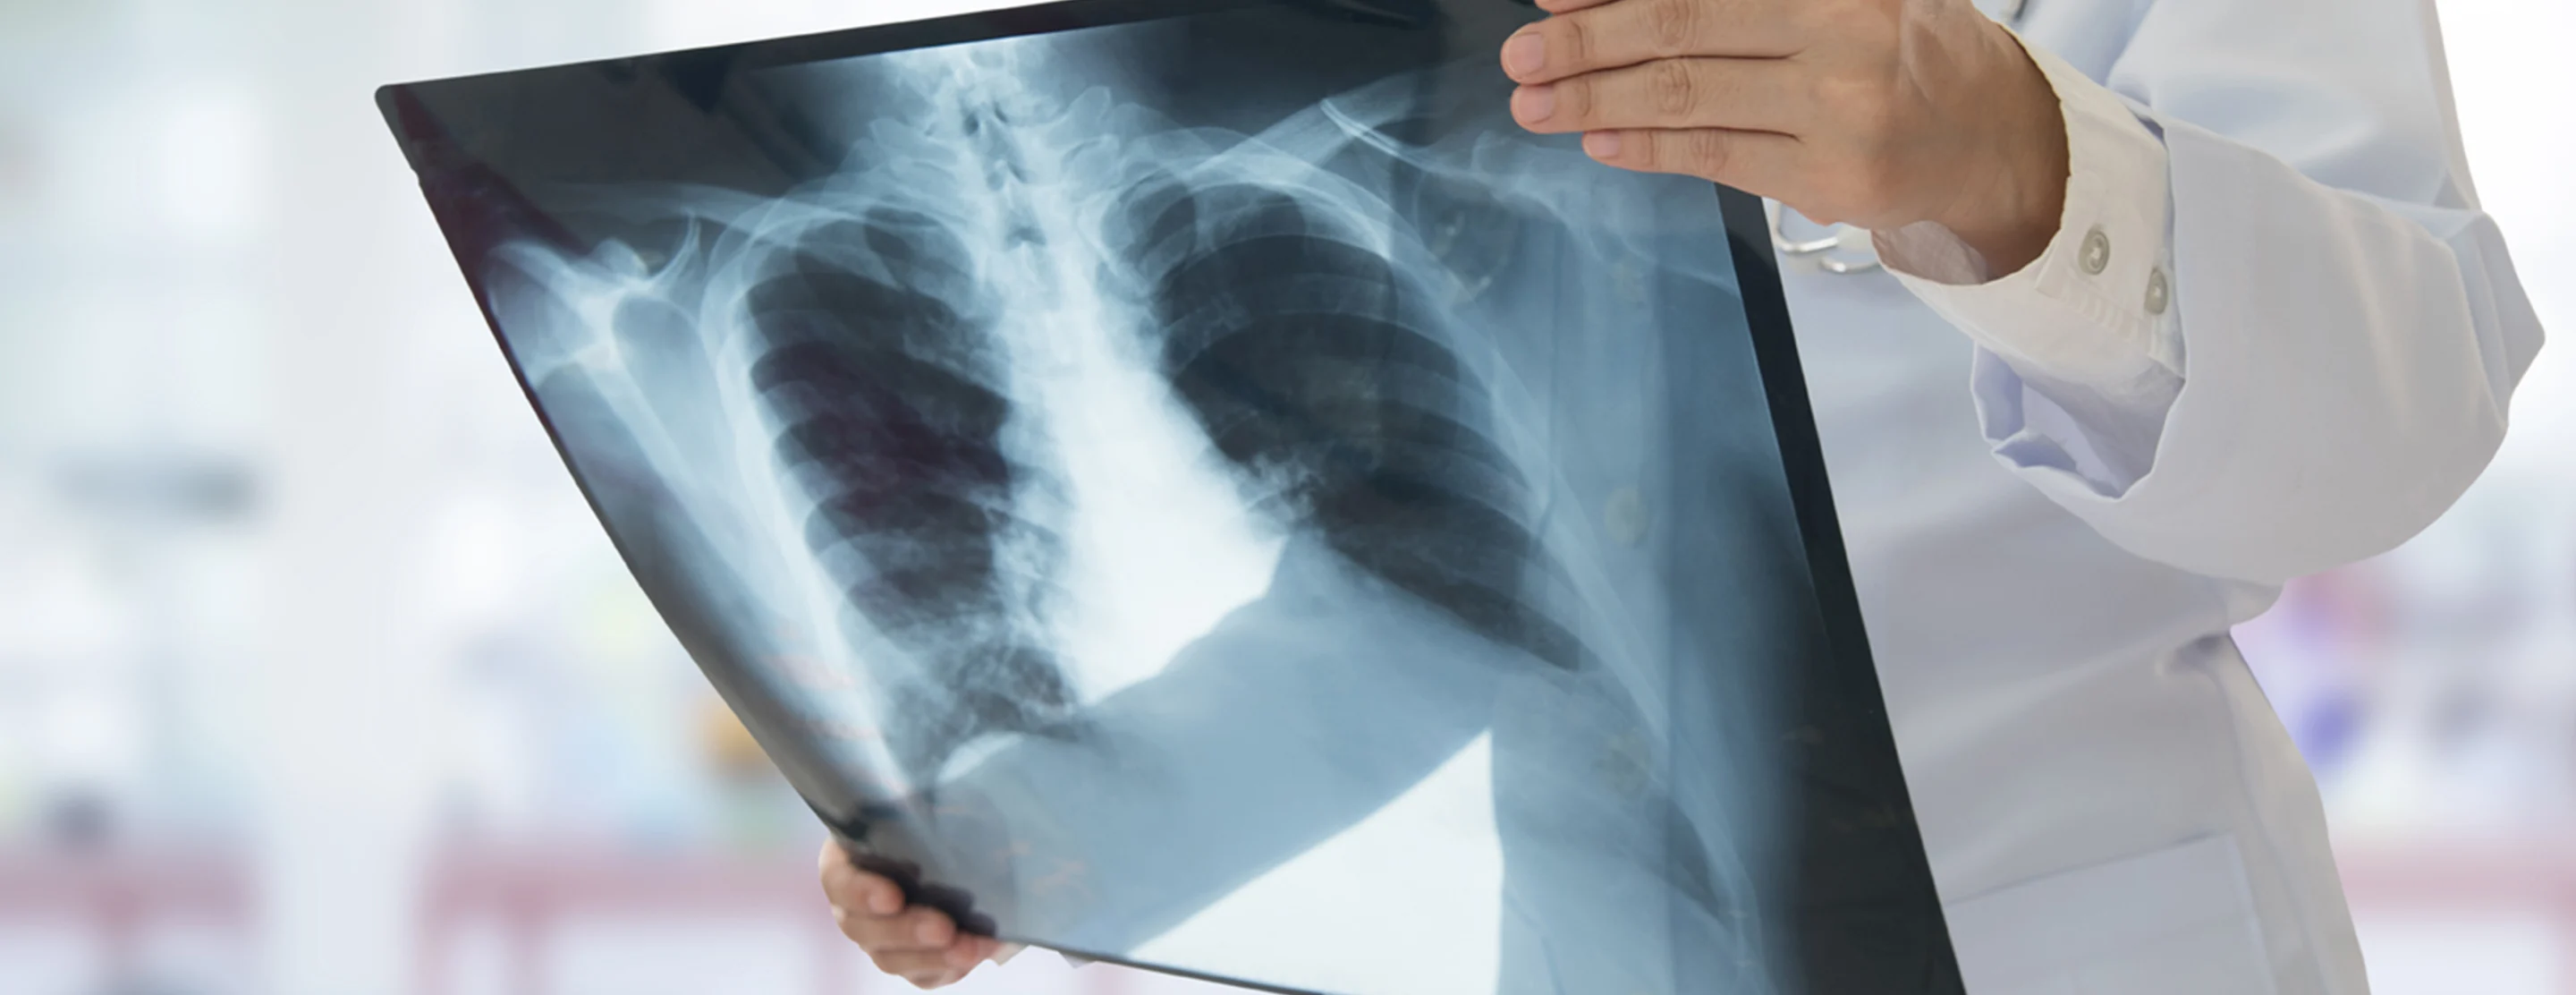

**Premise:** Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In this project, we devise a model to work with Chest X-Ray (CXR) images.

**Objective:** The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color="blue"> Data Pre-processing

### Loading all the relevant libraries.

In [24]:
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [25]:
#reading the data from the drive
DATASET_PATH = '/content/drive/MyDrive/CXR_data'

# There are two classes of images that we will deal with
#"nofinding" refers to the normal lungs.
#"effusion" is a buildup of fluid between the layers of tissue that line the lungs and chest cavity and we wish o detect this.
disease_cls = ['effusion', 'nofinding']

### Let's read the "effusion" and "nofinding" images.

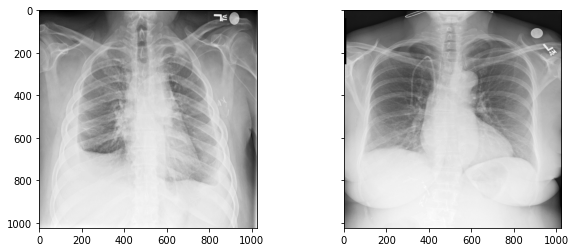

In [27]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [28]:
#lets check the effusion image shape
effusion.shape

(1024, 1024)

In [29]:
#lets check the normal image shape
normal.shape

(1024, 1024)

### Data Augmentation 

Now that we have read the images, the next step is data augmentation. We will the concept of a "data generator" for this purpose.

In [30]:
from skimage.transform import rescale
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,) #since these are x-ray images and have a certain orientation we need to be careful while selecting the hyperparameters.

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## <font color="blue"> Model building

We will be using a Resnet model in this project. The resnet model to be used in this project is stored in a .py file.


In [31]:
%cd /content/drive/MyDrive/CXR_data/

/content/drive/MyDrive/CXR_data


In [32]:
!python resnet.py

In [33]:
import resnet

In [34]:
img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [35]:
import numpy as np
import tensorflow as tf

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

## <font color="blue"> Ablation Run

The original meaning of “Ablation” is the surgical removal of body tissue. The term “Ablation study” has its roots in the field of experimental neuropsychology of the 1960s and 1970s, where parts of animals’ brains were removed to study the effect that this had on their behaviour.

In the context of machine learning, and especially complex deep neural networks, “ablation study” has been adopted to describe a procedure where certain parts of the network are removed, in order to gain a better understanding of the network’s behaviour.

For the following section, we'll be using this very concept to fine tune our model.

In [36]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=validation_generator)

1/1 [==============================] - 15s 15s/step - loss: 1.6115 - accuracy: 0.7500


In [37]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 15s 15s/step - loss: 1.5130 - accuracy: 0.8750
Epoch 2/5
1/1 [==============================] - 12s 12s/step - loss: 1.3928 - accuracy: 0.9062
Epoch 3/5
1/1 [==============================] - 12s 12s/step - loss: 1.3338 - accuracy: 0.9062
Epoch 4/5
1/1 [==============================] - 12s 12s/step - loss: 1.3080 - accuracy: 0.9032
Epoch 5/5
1/1 [==============================] - 12s 12s/step - loss: 1.2886 - accuracy: 0.9062


**Accuracy is an important metric but in imbalanced data, it is advisable to select AUC as a metric for determination of the model performance. We will do the same for our model.**

In [38]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [39]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
1/1 [==============================] - 3s 3s/step

Val AUC for epoch0: 0.4568965517241379
5/5 [==============================] - 74s 15s/step - loss: 1.4322 - accuracy: 0.8258 - val_loss: 2.4309 - val_accuracy: 0.9375 - val_auc: 0.4569
Epoch 2/5
1/1 [==============================] - 2s 2s/step

Val AUC for epoch1: 0.5458333333333334
5/5 [==============================] - 71s 14s/step - loss: 1.2984 - accuracy: 0.8974 - val_loss: 2.7940 - val_accuracy: 0.9062 - val_auc: 0.5458
Epoch 3/5
1/1 [==============================] - 2s 2s/step

Val AUC for epoch2: 0.44354838709677413
5/5 [==============================] - 68s 13s/step - loss: 1.2958 - accuracy: 0.8961 - val_loss: 1.8610 - val_accuracy: 0.9375 - val_auc: 0.4435
Epoch 4/5
1/1 [==============================] - 2s 2s/step

Val AUC for epoch3: 0.06666666666666665
5/5 [==============================] - 70s 13s/step - loss: 1.2879 - accuracy: 0.8968 - val_loss: 1.3528 - val_accuracy: 0.9688 - val_auc: 0.0667
Epoch 5/5
1/1 

Since the AUC is low, we introduce weighted categorical cross entropy (giving more weights to misclassifications) in place of simple categorical cross entropy as a loss function. 

In [40]:
from functools import partial
import tensorflow.keras.backend as K
from itertools import product
def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [41]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit(training_generator, epochs=1, validation_data=None)

1/1 [==============================] - 15s 15s/step - loss: 1.6956 - accuracy: 0.9375


## <font color="blue"> Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [42]:
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [43]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
1/1 [==============================] - 2s 2s/step

Val AUC for epoch0: 0.546524064171123

Epoch 1: val_auc improved from -inf to 0.54652, saving model to models/best_model.hdf5
13/13 [==============================] - 186s 14s/step - loss: 2.3414 - accuracy: 0.5013 - val_loss: 3.4463 - val_accuracy: 0.8854 - val_auc: 0.5465
Epoch 2/10
1/1 [==============================] - 2s 2s/step

Val AUC for epoch1: 0.5142045454545454

Epoch 2: val_auc did not improve from 0.54652
13/13 [==============================] - 180s 14s/step - loss: 2.2712 - accuracy: 0.5379 - val_loss: 3.4540 - val_accuracy: 0.8854 - val_auc: 0.5142
Epoch 3/10
1/1 [==============================] - 2s 2s/step

Val AUC for epoch2: 0.6679438058748404

Epoch 3: val_auc improved from 0.54652 to 0.66794, saving model to models/best_model.hdf5
13/13 [==============================] - 180s 14s/step - loss: 2.1973 - accuracy: 0.5620 - val_loss: 2.2436 - val_accuracy: 0.9167 - val_auc: 0.6679
Epoch 4/10
1/1 [=========

So, the val_auc is 0.7444 for the model, so let's try using it for making prediction.

## <font color="blue">. Making a Prediction

In [44]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

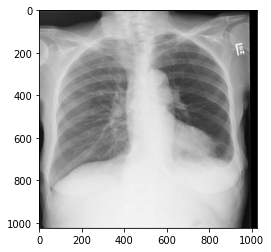

In [45]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-8])
plt.imshow(effusion,cmap='gray')

In [46]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

1/1 [==============================] - 0s 404ms/step


array([[0.68036413, 0.3196359 ]], dtype=float32)

**Thank You!**